## Filtering Labels

In [8]:
from segment_everything.detect_and_segment import segment_from_stacked_labels
from segment_everything.prompt_generator import YoloDetector
from segment_everything.weights_helper import get_weights_path
from segment_everything.stacked_labels import StackedLabels
from segment_everything.detect_and_segment import segment_from_stacked_labels
import matplotlib.pyplot as plt
from tnia.plotting.plt_helper import random_label_cmap, mask_overlay, imshow_multi2d

In [2]:
conf = 0.5
iou = 0.8
imagesz = 1024
descriptor = "MobileSAM Model"
boxes = True

yolo_detecter = YoloDetector(str(get_weights_path("ObjectAwareModel")), "ObjectAwareModelFromMobileSamV2", device='cuda')
        

In [3]:
from skimage.io import imread

image_name = r'C:\Users\bnort\work\ImageJ2022\tnia\notebooks-and-napari-widgets-for-dl\data\ladybugs_series\5784124_7185843.jpg'
img = imread(image_name)

In [4]:
results = yolo_detecter.get_results(img, conf=conf, iou= iou, imgsz=imagesz, max_det=10000)
bbs=results[0].boxes.xyxy.cpu().numpy()
stacked_labels = StackedLabels.from_yolo_results(bbs, None, img)
segmented_stacked_labels = segment_from_stacked_labels(stacked_labels, "MobileSamV2")
segmented_stacked_labels.sort_largest_to_smallest()
labels = segmented_stacked_labels.make_2d_labels(type="min")
        


0: 1024x928 18 objects, 169.6ms
Speed: 9.9ms preprocess, 169.6ms inference, 68.7ms postprocess per image at shape (1, 3, 1024, 1024)


VIT checkpoint loaded successfully


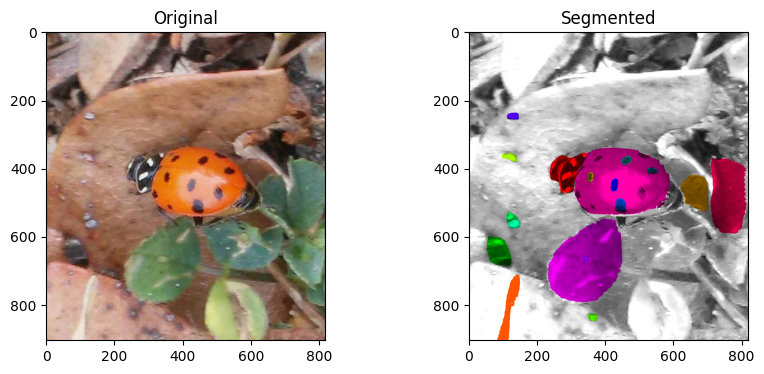

In [11]:
overlay_img = mask_overlay(img, labels)

#plt.imshow(overlay_img, cmap=random_label_cmap())
fig = imshow_multi2d([img, overlay_img], ["Original", "Segmented"], 1, 2)

In [45]:
from skimage import color
from skimage.measure import regionprops

def filter_labels_3d_multi(label_image, sorted_results, stat_limits):
    for enum, result in enumerate(sorted_results):
        # Check if the result should be kept based on the limits in stat_limits
        keep = all(
            stat_limits[stat]["min"] <= result[stat] <= stat_limits[stat]["max"]
            for stat in stat_limits
        )
        '''
        print(result['area'], stat_limits['area']['min'], stat_limits['area']['max'])
        print(result['circularity'], stat_limits['circularity']['min'], stat_limits['circularity']['max'])
        print(result['solidity'], stat_limits['solidity']['min'], stat_limits['solidity']['max'])
        print(result['mean_intensity'], stat_limits['mean_intensity']['min'], stat_limits['mean_intensity']['max'])
        print(result['10th_percentile_intensity'], stat_limits['10th_percentile_intensity']['min'], stat_limits['10th_percentile_intensity']['max'])
        print(result['mean_hue'], stat_limits['mean_hue']['min'], stat_limits['mean_hue']['max'])
        print(result['mean_saturation'], stat_limits['mean_saturation']['min'], stat_limits['mean_saturation']['max'])
        
        print(keep)
        print()
        '''
        if keep:
            if result["keep"] == True:
                continue
            result["keep"] = True
            coords = np.where(result["segmentation"])
            temp = label_image[enum, :, :]
            temp[coords] = enum + 1
        else:
            if result["keep"] == False:
                continue
            result["keep"] = False
            coords = np.where(result["segmentation"])
            temp = label_image[enum, :, :]
            temp[coords] = 0
            
def add_properties_to_label_image(orig_image, sorted_results):

    hsv_image = color.rgb2hsv(orig_image)
    # switch to this? https://forum.image.sc/t/looking-for-a-faster-version-of-rgb2hsv/95214/12

    hue = 255 * hsv_image[:, :, 0]
    saturation = 255 * hsv_image[:, :, 1]
    intensity = 255 * hsv_image[:, :, 2]

    for enum, result in enumerate(sorted_results):
        segmentation = result["segmentation"]
        coords = np.where(segmentation)
        regions = regionprops(segmentation.astype("uint8"))

        # calculate circularity
        result["circularity"] = (
            4 * np.pi * regions[0].area / (regions[0].perimeter ** 2)
        )
        # for small pixelated objects, circularity can be > 1 so we cap it
        if result["circularity"] > 1:
            result["circularity"] = 1

        result["solidity"] = regions[0].solidity
        intensity_pixels = intensity[coords]
        result["mean_intensity"] = np.mean(intensity_pixels)
        result["10th_percentile_intensity"] = np.percentile(
            intensity_pixels, 10
        )
        hue_pixels = hue[coords]
        result["mean_hue"] = np.mean(hue_pixels)
        saturation_pixels = saturation[coords]
        result["mean_saturation"] = np.mean(saturation_pixels)

        result['keep'] = True
        result["label_num"] = enum + 1
        print(enum+1)
        


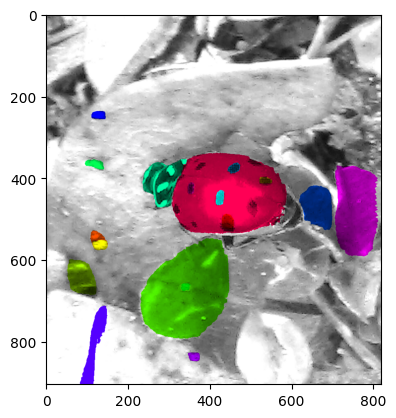

In [47]:
stat_limits = {
    "area": {"min": 0, "max": 100000},
    "label_num": {"min": -100000000, "max": 10000000000},
    "solidity": {"min": 0.0, "max": 1.0},
    "circularity": {"min": 0.0, "max": 1.0},
    "mean_intensity": {"min": 0, "max": 255},
    "10th_percentile_intensity": {"min": 0, "max": 255},
    "mean_hue": {"min": 0, "max": 360},
    "mean_saturation": {"min": 0.0, "max": 1000},
    "predicted_iou": {"min": 0.0, "max": 1.0},
    "stability_score": {"min": 0.0, "max": 1.0}
}

temp = stacked_labels.mask_list.copy()

stacked_labels.make_3d_label_image()

filter_labels_3d_multi(segmented_stacked_labels.label_image, segmented_stacked_labels.mask_list, stat_limits)

# min project label_image
masked_label_image = np.ma.masked_equal(segmented_stacked_labels.label_image, 0)
# Perform the min projection on the masked array
_2d_labels = np.ma.min(masked_label_image, axis=0).filled(0)

test = mask_overlay(img, _2d_labels)
plt.imshow(test, cmap=random_label_cmap())


In [34]:
add_properties_to_label_image(img, segmented_stacked_labels.mask_list)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [11]:
import napari
from  napari_segment_everything import segment_everything

viewer = napari.Viewer()
segment_everything_widget=segment_everything.NapariSegmentEverything(viewer)
viewer.window.add_dock_widget(segment_everything_widget)
segment_everything_widget.load_project(segmented_stacked_labels.image, segmented_stacked_labels.mask_list)


area 192.0 27982.0
label_num 1 39
solidity 0.32764505119453924 0.9727636181909045
circularity 0.19237908137929463 0.8234817265690586
mean_intensity 25.31562302340291 197.359375
10th_percentile_intensity 4.0 184.1
mean_hue 20.537680290775494 75.34663411191669
mean_saturation 85.16564983216925 217.41005184234092
predicted_iou 0.5472383499145508 0.980248212814331
stability_score 0.6202531456947327 0.9825803637504578
